## PoE, 14 datasets, one layer (run one by one)

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import sys
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.optim as optim
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
torch.manual_seed(0)
np.random.seed(0)
import random
random.seed(0)
sys.path.append('/Users/siyuhe/Spatial_project')
import PoE.utils as utils
import PoE.dataloader_1002 as dataloader
import PoE.utils_plots as utils_plots
import anndata

### Prepare expression data

In [2]:
sample_ids = ['MBC_1A',
             'MBC_1B',
             'MBC_2A',
             'MBC_2B',
             'MBC_3A',
             'MBC_3B',
             'MBC_4A',
             'MBC_4B',
              'CID4290',
             'CID4465',
             'CID4535',
             'CID444971',
             '1142243F',
             '1160920F'
            ]

In [3]:
# load all expression data  [spot x gene]
data_path = '../data'
sample_id = 'CID444971'

#adata_sample = sc.read_visium(path=os.path.join(data_path, sample_id),library_id =  sample_id)
#adata_sample.var_names_make_unique()
#adata_sample.obs['sample']=sample_id
#adata_sample.obs_names  = adata_sample.obs_names+'-'+sample_id
    

adata_sample = sc.read_h5ad("../data/"+sample_id+"/"+sample_id+".h5ad")
adata_sample.var_names_make_unique()
adata_sample.obs['sample']=sample_id
adata_sample.obs_names  = adata_sample.obs_names+'-'+sample_id

In [4]:
adata_sample = utils.exp_preprocess(adata_sample,n_top_genes=2000) 

Preprocessing1: delete the mt and rp
Preprocessing2: Normalize
Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


/Users/siyuhe/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
adata_sample

AnnData object with n_obs × n_vars = 1162 × 19128
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Prepare Signature

In [6]:
# load signature data [type x gene]
signature_path = data_path
sig_fname = os.path.join(signature_path,  'bc_signatures_version_1216.csv')
df_sig = pd.read_csv(sig_fname)
df_sig.columns = df_sig.columns.str.replace('.', ' ')
df_sig.columns = df_sig.columns.str.replace('_', ' ')
df_sig.columns = df_sig.columns.str.replace('-', ' ')
df_sig.columns = df_sig.columns.str.replace('+', '')

<ipython-input-6-b446dda5ce14>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_sig.columns = df_sig.columns.str.replace('.', ' ')
<ipython-input-6-b446dda5ce14>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_sig.columns = df_sig.columns.str.replace('+', '')


In [7]:
df_sig

Th17  B cell NK cell Macrophages Macrophage M2    vCAFs Endothelial  \
0     RORC    CD19   KLRD1       ITGAX        LAPTM5   NOTCH3         VWF   
1     RORA  CD40LG   NCAM1       ITGAM         LAIR1    EPAS1      PECAM1   
2    RUNX1    IGHD    NCR1        CD68           CD4  COL18A1        CD36   
3    CEBPB    EBF1   KLRK1        CD14         CSF1R    NR2F2       EGFL7   
4   CLEC7A    TCF3    GNLY      MARCH1         CD163    CSPG4        FLT1   
..     ...     ...     ...         ...           ...      ...         ...   
66     NaN     NaN     NaN         NaN           NaN      NaN         NaN   
67     NaN     NaN     NaN         NaN           NaN      NaN         NaN   
68     NaN     NaN     NaN         NaN           NaN      NaN         NaN   
69     NaN     NaN     NaN         NaN           NaN      NaN         NaN   
70     NaN     NaN     NaN         NaN           NaN      NaN         NaN   

      mCAFs   dCAFS   MDSC  ...   cDC     pDC Terminal exhaustion  \
0       DCN   SNAI2  ITGAM  ...  CD80   IL3RA                CD3G   
1       LUM  TWIST1   CD33  ...  CD86  LILRA4               FASLG   
2      VCAN   SCRG1   ARG1  ...  CCR7   CD123                 ID2   
3   COL14A1    SOX9   NOS2  ...  CD1A    TCF4                LAG3   
4     FBLN1   SOX10   CD68  ...  CD1C    IRF7                RGS1   
..      ...     ...    ...  ...   ...     ...                 ...   
66      NaN     NaN    NaN  ...   NaN     NaN                 NaN   
67      NaN     NaN    NaN  ...   NaN     NaN                 NaN   
68      NaN     NaN    NaN  ...   NaN     NaN                 NaN   
69      NaN     NaN    NaN  ...   NaN     NaN                 NaN   
70      NaN     NaN    NaN  ...   NaN     NaN                 NaN   

   Precursor exhaustion CAFs MSC iCAF like CAFs myCAF like PVL differentiated  \
0                  TCF7               APOD          COL1A1              ACTA2   
1                MS4A4A                DCN          COL1A2              TAGLN   
2                TNFSF8              PTGDS          COL3A1               MYL9   
3                CXCL10                CFD             LUM               TPM2   
4                EEF1B2                LUM           SFRP2           NDUFA4L2   
..                  ...                ...             ...                ...   
66                  NaN                NaN             NaN                NaN   
67                  NaN                NaN             NaN                NaN   
68                  NaN                NaN             NaN                NaN   
69                  NaN                NaN             NaN                NaN   
70                  NaN                NaN             NaN                NaN   

   PVL immature Normal epithelial Plasmablasts  
0         CCL19             KRT14     IGKV3-15  
1          RGS5             KRT17        IGHG1  
2        IGFBP7               LTF      IGKV1-5  
3      NDUFA4L2             KRT15     IGKV3-20  
4          CCL2               PTN     IGKV3-11  
..          ...               ...          ...  
66          NaN               NaN          NaN  
67          NaN               NaN          NaN  
68          NaN               NaN          NaN  
69          NaN               NaN          NaN  
70          NaN               NaN          NaN  

[71 rows x 26 columns]

### Prepare gsva

In [8]:
df_gsva_raw= pd.read_csv(os.path.join('../results/01_gsva_folder', sample_id+'_gsva.csv'), index_col=0).transpose()
df_gsva_raw.index = df_gsva_raw.index+'-'+sample_id
df_gsva_raw.columns = df_sig.columns

In [9]:
df_gsva_raw

Th17    B cell   NK cell  Macrophages  \
AACATTGGTCAGCCGT-1-CID444971 -0.402649 -0.083351  0.619113    -0.605424   
CATCGAATGGATCTCT-1-CID444971 -0.033911  0.302848  0.598822    -0.249764   
CGGGTTGTAGCTTTGG-1-CID444971 -0.127673 -0.320333  0.303730    -0.257799   
CCTAAGTGTCTAACCG-1-CID444971 -0.108592 -0.090638  0.615729    -0.165753   
TCTGTGACTGACCGTT-1-CID444971 -0.274806 -0.380077  0.510931    -0.691783   
...                                ...       ...       ...          ...   
TGCAGTGGTAGGGAAC-1-CID444971 -0.336230  0.163180  0.544632    -0.437697   
AGCGAGACGTGAAGGC-1-CID444971 -0.306599  0.214415  0.436239    -0.160275   
CAGTGTTAATCTCTCA-1-CID444971 -0.183308  0.340649  0.583460    -0.221502   
GATCGCTGTGGTGCGT-1-CID444971 -0.447447  0.357382  0.536103    -0.691024   
CTCTGCAGGCATTCTT-1-CID444971 -0.225801  0.047965  0.590546     0.031002   

                              Macrophage M2     vCAFs  Endothelial     mCAFs  \
AACATTGGTCAGCCGT-1-CID444971      -0.667789 -0.716407    -0.242090 -0.718150   
CATCGAATGGATCTCT-1-CID444971      -0.696380 -0.493635    -0.528611 -0.081979   
CGGGTTGTAGCTTTGG-1-CID444971      -0.267282 -0.744684    -0.262309 -0.446987   
CCTAAGTGTCTAACCG-1-CID444971      -0.667751 -0.484767    -0.283975 -0.183023   
TCTGTGACTGACCGTT-1-CID444971      -0.601969 -0.420021    -0.569497 -0.174217   
...                                     ...       ...          ...       ...   
TGCAGTGGTAGGGAAC-1-CID444971      -0.061540 -0.075697    -0.577198  0.495429   
AGCGAGACGTGAAGGC-1-CID444971      -0.228871 -0.555368    -0.097071 -0.377013   
CAGTGTTAATCTCTCA-1-CID444971      -0.363721  0.023132    -0.549657  0.276698   
GATCGCTGTGGTGCGT-1-CID444971      -0.733397  0.400083     0.769507  0.229987   
CTCTGCAGGCATTCTT-1-CID444971      -0.713263 -0.754853    -0.025351  0.012517   

                                 dCAFS      MDSC  ...       cDC       pDC  \
AACATTGGTCAGCCGT-1-CID444971 -0.562349 -0.133764  ...  0.215578 -0.085451   
CATCGAATGGATCTCT-1-CID444971 -0.615511 -0.234039  ...  0.279745  0.084171   
CGGGTTGTAGCTTTGG-1-CID444971 -0.300786 -0.295313  ... -0.017905 -0.266562   
CCTAAGTGTCTAACCG-1-CID444971 -0.564432 -0.139824  ...  0.208741 -0.091614   
TCTGTGACTGACCGTT-1-CID444971 -0.733070 -0.127818  ... -0.055504  0.528816   
...                                ...       ...  ...       ...       ...   
TGCAGTGGTAGGGAAC-1-CID444971 -0.714219 -0.404942  ...  0.163686  0.041865   
AGCGAGACGTGAAGGC-1-CID444971  0.154592 -0.167404  ...  0.017911 -0.472132   
CAGTGTTAATCTCTCA-1-CID444971 -0.648929  0.029149  ...  0.089882  0.171427   
GATCGCTGTGGTGCGT-1-CID444971 -0.291724 -0.399803  ... -0.022103 -0.350780   
CTCTGCAGGCATTCTT-1-CID444971 -0.645175 -0.289245  ...  0.143641 -0.235572   

                              Terminal exhaustion  Precursor exhaustion  \
AACATTGGTCAGCCGT-1-CID444971            -0.291295             -0.341069   
CATCGAATGGATCTCT-1-CID444971            -0.162314             -0.072978   
CGGGTTGTAGCTTTGG-1-CID444971             0.084144             -0.096149   
CCTAAGTGTCTAACCG-1-CID444971            -0.296495             -0.581852   
TCTGTGACTGACCGTT-1-CID444971            -0.418053             -0.174083   
...                                           ...                   ...   
TGCAGTGGTAGGGAAC-1-CID444971            -0.036929             -0.347605   
AGCGAGACGTGAAGGC-1-CID444971            -0.386312              0.159136   
CAGTGTTAATCTCTCA-1-CID444971            -0.116438             -0.316838   
GATCGCTGTGGTGCGT-1-CID444971            -0.080705              0.029937   
CTCTGCAGGCATTCTT-1-CID444971            -0.223244             -0.061405   

                              CAFs MSC iCAF like  CAFs myCAF like  \
AACATTGGTCAGCCGT-1-CID444971           -0.569112        -0.495581   
CATCGAATGGATCTCT-1-CID444971           -0.413360        -0.289626   
CGGGTTGTAGCTTTGG-1-CID444971           -0.246659        -0.624791   
CCTAAGTGTCTAACCG-1-CID444971           -0.429019        -0.568343   
T

## Prepare images

In [10]:
from __future__ import print_function

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import cv2
#plt.rcParams['figure.figsize'] = 15, 15
#plt.rcParams['image.cmap'] = 'gray'
#titlesize = 24

In [11]:
# image preparation

adata_image = io.imread(os.path.join(data_path, sample_id, 'spatial','tissue_hires_image.png'))
adata_image = (adata_image*255).astype(np.uint8)
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains
# create stain matrix
# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T
# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(adata_image, W)

adata_image = imDeconvolved.Stains[:,:,0]
adata_image = ((adata_image - adata_image.min())/(adata_image.max()-adata_image.min()) *255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(15,15))

adata_image = clahe.apply(adata_image)

adata_image = (adata_image - adata_image.min())/(adata_image.max()-adata_image.min())
#adata_image = np.clip(adata_image, 0.2, 0.8)
#adata_image = (adata_image - adata_image.min())/(adata_image.max()-adata_image.min())

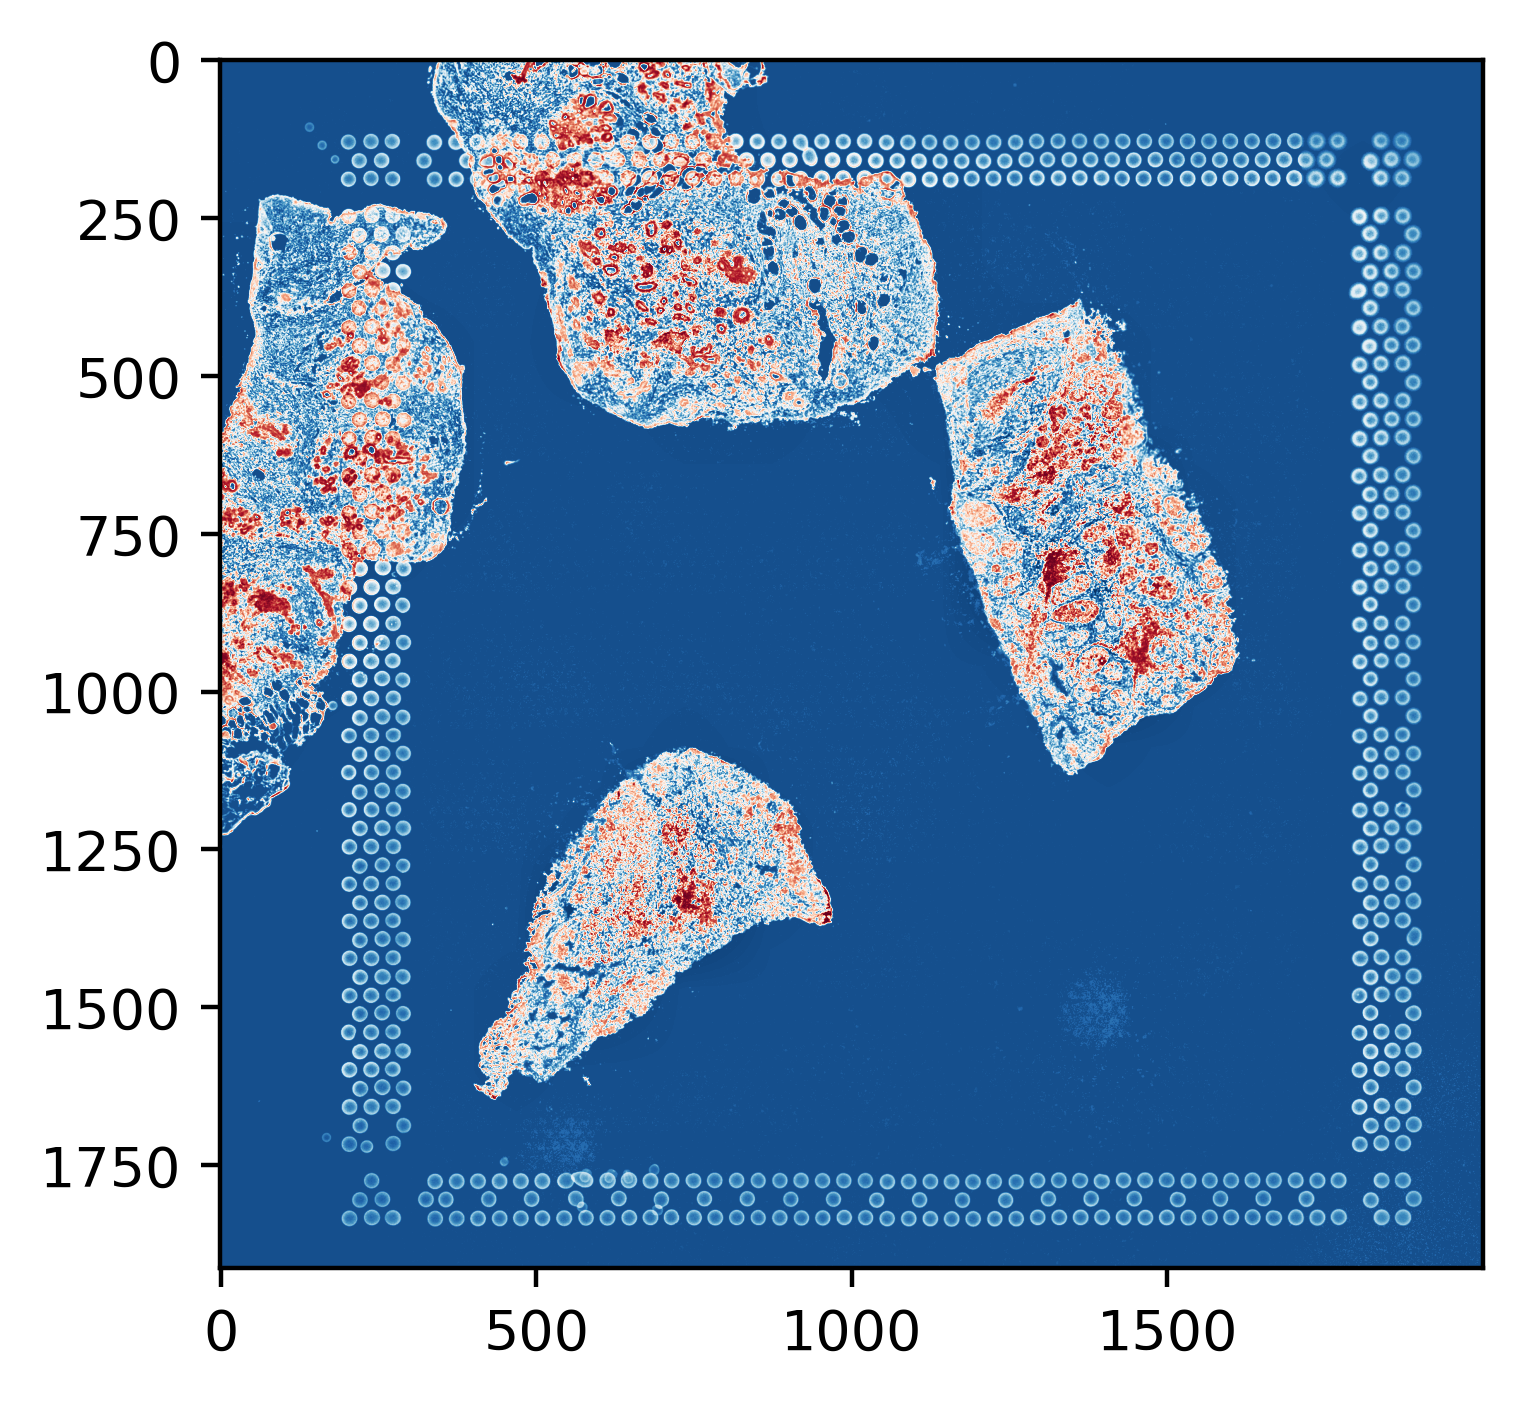

In [12]:
plt.figure(dpi=400)
plt.imshow(adata_image,cmap='RdBu_r')

## Mapping images to location

In [14]:
map_info = []

import json


f = open(os.path.join(data_path, sample_id, 'spatial','scalefactors_json.json',))
json_info = json.load(f)
f.close()
tissue_hires_scalef = json_info['tissue_hires_scalef']
    
tissue_position_list = pd.read_csv(os.path.join(data_path, sample_id, 'spatial','tissue_positions_list.csv'),header=None, index_col=0)
tissue_position_list.index = tissue_position_list.index+'-'+sample_id
tissue_position_list = tissue_position_list.loc[adata_sample.obs.index,:]
map_info= tissue_position_list.iloc[:,1:3]
map_info.columns=['array_row','array_col']
map_info.loc[:,'imagerow'] = tissue_position_list.iloc[:,3] *tissue_hires_scalef
map_info.loc[:,'imagecol'] = tissue_position_list.iloc[:,4] *tissue_hires_scalef
map_info.loc[:,'sample'] = sample_id


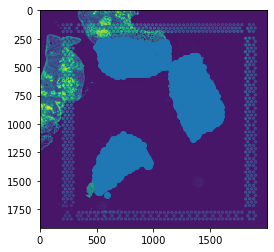

In [15]:
test = map_info
plt.imshow(adata_image)
plt.scatter(test['imagecol'],test['imagerow'])

## define the varibale geneset, and signature geneset, and create dataloader

In [16]:
def gene_for_train(adata, df_sig):
    """find the varibale gene name, the mattered gene signatures, and the combined variable+signature for training"""
    
    variable_gene = adata.var_names[adata.var['highly_variable']]
    print('the number of original variable genes in the dataset',variable_gene.shape)
    print('the number of siganture genes in the dataset',np.unique(df_sig.values.flatten().astype(str)).shape)
    
    # filter out some genes in the signature not in the var_names
    sig_gname_filtered =  np.intersect1d(adata.var_names,np.unique(df_sig.values.flatten().astype(str)))
    print('after filter out some genes in the signature not in the var_names ...',sig_gname_filtered.shape)
    # filter out some genes not highly expressed in the signature
    sig_gname_filtered = sig_gname_filtered[adata.to_df().loc[:,sig_gname_filtered].sum()>0]
    print('after filter out some genes not highly expressed in the signature ...', sig_gname_filtered.shape)
    
    sig_variable_gene_inter  = set([*np.array(variable_gene) ,*sig_gname_filtered])
    print('combine the varibale and siganture, the total unique gene number is ...', len(sig_variable_gene_inter))
    
    return variable_gene, sig_gname_filtered, sig_variable_gene_inter

In [17]:
adata_sample

AnnData object with n_obs × n_vars = 1162 × 19128
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [18]:
variable_gene, sig_gname_filtered, sig_variable_gene_inter = gene_for_train(adata_sample, df_sig)

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (537,)
after filter out some genes in the signature not in the var_names ... (497,)
after filter out some genes not highly expressed in the signature ... (491,)
combine the varibale and siganture, the total unique gene number is ... 2379


In [19]:
# prepare dataset for training
adata_df_variable = adata_sample.to_df().loc[:,variable_gene]
adata_df_signature = adata_sample.to_df().loc[:,sig_gname_filtered]

In [20]:
# datasets
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
import numpy as np

class shenet_traindatastack(torch.utils.data.Dataset):
    """
    return the data stack with expression and image 
    """

    def __init__(self, train_data,map_info,patch_r):

        super(shenet_traindatastack, self).__init__()
        self.genexp = train_data[0]
        self.genexp_sig = train_data[1]
        self.image = train_data[2]
        self.map_info =  map_info
        self.spot_img_stack = []
        
        for i in range(len(self.genexp)):
            img_xmin = int(self.map_info.iloc[i]['imagecol'])-patch_r
            img_xmax = int(self.map_info.iloc[i]['imagecol'])+patch_r
            img_ymin = int(self.map_info.iloc[i]['imagerow'])-patch_r
            img_ymax = int(self.map_info.iloc[i]['imagerow'])+patch_r
            self.spot_img_stack.append(self.image[img_ymin:img_ymax,img_xmin:img_xmax])

    def __getitem__(self, idx):
        return np.array(self.genexp.iloc[idx]),np.array(self.genexp_sig.iloc[idx]),self.spot_img_stack[idx],self.map_info.index[idx]

    def __len__(self):
        return len(self.genexp)

In [21]:
# create data loader
batch_size = 8
patch_r = 13
trainset = shenet_traindatastack([adata_df_variable, adata_df_signature, adata_image],map_info,patch_r)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

## define the pure and peri spots

In [22]:
# deadling with gsva and siganture
def discretize_gsva(gsva_raw, thld=0.7):
    """
    Discretize GSVA scores for training
    
    Parameters
    ----------
    gsva_raw : pd.DataFrame
        raw GSVA matrix (shape: [S x C])
    
    """
    gsva_train = gsva_raw.apply(
        lambda x: x >= x.quantile(thld), 
        axis=0
    ).astype(np.uint8)
    
    return gsva_train


def find_spots(adata, gsva, n_nbrs=20):
    """
    Find spots representing `pure spots` & their nearest neighbors
    based on GSVA scores for each cell type
    """
    assert 'highly_variable' in adata.var_keys(), \
        "Please choose highly variable genes first"
    
    # Calculate distance with only highly variable genes
    embedding = adata[:, adata.var['highly_variable']].X.A
    pure_idxs = np.argmax(gsva.values, axis=0)
    pure_spots = gsva.idxmax(axis=0)
    
    pure_dict = {
        spot: ct 
        for (spot, ct) in zip(pure_spots, gsva.columns)
    }
    
    nbrs = NearestNeighbors(n_neighbors=n_nbrs+len(pure_spots)).fit(embedding)
    nn_graph = nbrs.kneighbors(embedding)[1] 
    
    perif_spots = []        
    perif_idxs = [nn_graph[idx].tolist() for idx in pure_idxs]
    for i, raw_idxs in enumerate(perif_idxs):
        idxs = [idx 
                for idx in raw_idxs 
                if idx not in pure_idxs or idx == raw_idxs[0]]
        perif_spots.append(gsva.index[idxs[:n_nbrs]])
    
    perif_dict = {}
    for (spots, ct) in zip(perif_spots, gsva.columns):
        for spot in spots:
            if spot not in perif_dict.keys():
                perif_dict[spot] = [ct]
            else:
                perif_dict[spot].append(ct)
        
    pure_spots = np.asarray(pure_spots)
    perif_spots = np.asarray(perif_spots).flatten()
    
    adata.obs['pure_val'] = [
        pure_dict[spot] 
        if spot in pure_spots else 'nan' for spot in adata.obs_names 
    ]
    adata.obs['perif_val'] = [
        perif_dict[spot]
        if spot in perif_spots else [np.nan] for spot in adata.obs_names 
    ]
    adata.obs['perif_unique_val'] = adata.obs['perif_val'].apply(lambda x: x[0])

    return pure_spots, perif_spots
    

In [23]:
from sklearn.neighbors import NearestNeighbors
pure_spots, perif_spots = find_spots(adata_sample, df_gsva_raw)

In [24]:
spot_sizes = adata_sample.obs_names.map(lambda x: 500 if x in set(pure_spots) else 50)

In [25]:
pure_spots.shape,perif_spots.shape,spot_sizes.shape

((26,), (520,), (1162,))

In [26]:
# Configure signature & gsva dataframes
sig_genes_dict = {
    sig: df_sig[sig][~pd.isna(df_sig)[sig]].tolist() 
    for sig in df_sig.columns
}

# Discretize gsva scores given different thresholds
gsva_scores_train = discretize_gsva(df_gsva_raw)

In [46]:
## get the mean of arch and signature genes
mean_arch_ct = []# shape:n_pseudospots X len(gsva_scores1.columns)
#tt = adA.obs
#ttt = np.array(tt['arches_nn_ct'].unique())
#x[~numpy.isnan(x)]
for i in df_gsva_raw.columns:#cell_dic_plot.keys():#valid_cell_dic_ct.keys():#ttt[~np.isnan(ttt)]:#cell_dic_plot.keys():
    
    genes_sele = sig_genes_dict[i]
    mean_n = adata_sample.to_df().loc[perif_spots][adata_sample.to_df().columns.intersection(genes_sele)].sum(axis=1)/len(adata_sample.to_df().columns.intersection(genes_sele))
    mean_arch_ct.append(mean_n)#np.append(mean_arch_ct,mean_n)
    
mean_arch_ct = np.array(mean_arch_ct).T
mean_arch_ct.shape

(520, 26)

In [27]:
def calc_var_priors(adata, sig_genes_dict):
    """Calculate avg. gexp variance for each signature as priors"""
    # Subset signature genes as Union(marker_genes, highly_variable genes)
    marker_genes = list(set(
        [gene
         for genes in sig_genes_dict.values() 
         for gene in genes]
    ))
    hv_genes = adata.var_names[adata.var['highly_variable']]
    sel_genes = set(np.union1d(marker_genes, hv_genes))
    genes_dict = {}
    for ct, genes in sig_genes_dict.items():
        filtered_genes = [gene for gene in genes if gene in sel_genes]
        if len(filtered_genes) > 0:
            genes_dict[ct] = filtered_genes
            
    # Calculate signature variance priors
    sig_vars = []
    sig_vars_dict = {} 
    
    for ct, genes in genes_dict.items():
        spot_mask = adata.obs['perif_val'].apply(
            lambda x: ct in x
        ).astype(bool)
        gene_mask = adata.var_names.intersection(genes)
        ct_vars = adata[spot_mask, gene_mask].X.sum(axis=1).var()
        sig_vars.append(ct_vars)
        sig_vars_dict[ct] = ct_vars
        
    sig_vars = np.asarray(sig_vars)
    
    return sig_vars, sig_vars_dict, sel_genes

In [48]:
sig_vars, sig_vars_dict, sel_genes = calc_var_priors(adata_sample, sig_genes_dict) 
for k, v in sig_vars_dict.items():
    print("{0}: {1}".format(k, v))

Th17: 1.8299022912979126
B cell: 6.698885917663574
NK cell: 0.32368624210357666
Macrophages: 2.862227201461792
Macrophage M2: 10.030545234680176
vCAFs: 3.611356258392334
Endothelial: 3.850989580154419
mCAFs: 7.539035797119141
dCAFS: 0.4671204686164856
MDSC: 1.5275230407714844
MBC: 2.1370596885681152
TNBC: 22.033832550048828
Treg: 6.612895965576172
CD8 T cell activation: 10.844329833984375
CD8 deletional tolerance: 1.5674402713775635
CD8 TIL dysfunction: 5.217514991760254
cDC: 1.9562772512435913
pDC: 0.845639705657959
Terminal exhaustion: 8.580880165100098
Precursor exhaustion: 4.616244792938232
CAFs MSC iCAF like: 62.92244338989258
CAFs myCAF like: 90.40766906738281
PVL differentiated: 69.89765930175781
PVL immature: 56.15784454345703
Normal epithelial: 11.090149879455566
Plasmablasts: 48.67096710205078


In [49]:
x_sample_variable = torch.Tensor(adata_df_variable.loc[perif_spots].to_numpy())
x_sample_sig = torch.Tensor(adata_df_signature.loc[perif_spots].to_numpy())

gsva_sig = torch.Tensor(gsva_scores_train.loc[perif_spots, :].to_numpy())

In [50]:
gsva_sig_all = torch.Tensor(gsva_scores_train.to_numpy())

In [51]:
x_sample_variable.shape,x_sample_sig.shape

(torch.Size([520, 2000]), torch.Size([520, 491]))

## Define PoE model

In [52]:
class poe_model_sig(nn.Module):

    def __init__(self, adata_df_variable, adata_df_signature, patch_r):
        
        super(poe_model_sig, self).__init__()
        self.c_bn = len(sig_vars) # latent number, numbers of bottle neck
        self.c_in = adata_df_variable.shape[1]+adata_df_signature.shape[1] # number of genes
        self.patch_r = patch_r
        
        self.sig_vars_prior = torch.Tensor(sig_vars).to(device) # variance of signature/pure spots
        
        # For gene expression
        self.linVAE_enc = nn.Sequential(nn.Linear(self.c_in, 128, bias=True),
                                  nn.BatchNorm1d(128, momentum=0.01, eps=0.001),
                                  nn.ReLU(),
                                  )
        self.linVAE_fc_mu = nn.Linear(128+adata_df_signature.shape[1], self.c_bn)
        
        self.linVAE_z_fc = nn.Linear(self.c_bn, 128)
        
        self.linVAE_dec = nn.Sequential(
                                  nn.Linear(128+adata_df_signature.shape[1], self.c_in,bias=True),
                                  nn.BatchNorm1d(self.c_in, momentum=0.01, eps=0.001),
                                  #nn.ReLU(),
                                  )
        # For image 
        self.imgVAE_enc = nn.Sequential(nn.Linear(self.patch_r*self.patch_r*4, 128, bias=True), # flatten the images into 1D
                                  nn.BatchNorm1d(128, momentum=0.01, eps=0.001),
                                  nn.ReLU(),                                 
                                  )
        self.imgVAE_fc_mu = nn.Linear(128, self.c_bn)
        self.imgVAE_fc_logvar = nn.Linear(128, self.c_bn)
        

        self.imgVAE_z_fc = nn.Linear(self.c_bn, 128)
        self.imgVAE_dec = nn.Sequential(nn.Linear(128, 256, bias=True),
                                  nn.BatchNorm1d(256, momentum=0.01, eps=0.001),
                                  nn.ReLU(),  
                                  nn.Linear(256, self.patch_r*self.patch_r*4, bias=True),
                                  nn.BatchNorm1d(self.patch_r*self.patch_r*4, momentum=0.01, eps=0.001),
                                  #nn.ReLU(),                                 
                                  )
        
        # PoE
        self.POE_z_fc = nn.Linear(self.c_bn, 128)
        
        self.POE_dec_rna = nn.Sequential(
                                     nn.Linear(128+adata_df_signature.shape[1], self.c_in, bias=True),
                                     nn.BatchNorm1d(self.c_in, momentum=0.01, eps=0.001),
                                     #nn.ReLU(), 
                                  )
        
        self.POE_dec_img = nn.Sequential(      
                                  nn.Linear(128, self.patch_r*self.patch_r*4, bias=True),
                                  nn.BatchNorm1d(self.patch_r*self.patch_r*4, momentum=0.01, eps=0.001),
                                  #nn.ReLU(),           
                                  )
        
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    
    def predict_linVAE(self, x, x_sig, x_peri, x_peri_sig):     
        
        x_concat = torch.cat((x,x_sig),1)
        x_peri_concate = torch.cat((x_peri,x_peri_sig),1)
        batch, _ = x_concat.shape
        
        hidden = self.linVAE_enc(x_concat)
        hidden_peri = self.linVAE_enc(x_peri_concate)
        
        mu = self.linVAE_fc_mu(torch.cat((hidden,x_sig),1))
        mu_peri = self.linVAE_fc_mu(torch.cat((hidden_peri,x_peri_sig),1))
        
        sig_stds = torch.sqrt(self.sig_vars_prior)
        
        log_var = sig_stds.repeat(mu.shape[0], 1)
        log_var_peri = sig_stds.repeat(mu_peri.shape[0], 1)
        
        z = self.reparameterize(mu, log_var)
        z_peri = self.reparameterize(mu_peri, log_var_peri)
        
        x = self.linVAE_z_fc(z)
        x_peri = self.linVAE_z_fc(z_peri)
        
        recon = self.linVAE_dec(torch.cat((x,x_sig),1))
        recon_peri = self.linVAE_dec(torch.cat((x_peri,x_peri_sig),1))
        
        return recon, recon_peri, mu, log_var, mu_peri, log_var_peri
    
        
            
    def predict_imgVAE(self, x):

        batch, _= x.shape
        hidden = self.imgVAE_enc(x)
    
        mu = self.imgVAE_fc_mu(hidden)  
        log_var = self.imgVAE_fc_logvar(hidden)

        z = self.reparameterize(mu, log_var)

        x = self.imgVAE_z_fc(z) 
        reconstruction = self.imgVAE_dec(x)

        return reconstruction, mu, log_var
    
    
    def predictor_POE(self, mu_exp, logvar_exp, mu_peri, logvar_peri, mu_img, logvar_img, adata_sig,  x_peri, x_peri_sig):
        
        batch, _ = mu_exp.shape
        var_poe = torch.div(1., 
                            1 + 
                            torch.div(1., torch.exp(logvar_exp)) + 
                            torch.div(1., torch.exp(logvar_img))
                            )
        
        mu_poe = var_poe * (0 + 
                            mu_exp * torch.div(1., torch.exp(logvar_exp)+1e-5) + 
                            mu_img * torch.div(1., torch.exp(logvar_img)+1e-5)                           
                            )
        
        z = self.reparameterize(mu_poe, torch.log(var_poe+0.001))
        
        x = self.POE_z_fc(z)
        
        reconstruction_rna =  self.POE_dec_rna(torch.cat((x,adata_sig),1))
        #reconstruction_rna_peri =  self.POE_dec_rna(torch.cat((x_peri,x_peri_sig),1))
        
        reconstruction_img =  self.POE_dec_img(x)
        
        return reconstruction_rna , reconstruction_img, mu_poe,torch.log(var_poe+0.001)
    

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#import PoE.model_1002 as poe_model
# initialize the model
model = poe_model_sig(adata_df_variable, adata_df_signature, patch_r).to(device)

train_loss = []
# set the learning parameters
lr1 = 0.001
#lr2 = 0.0001
optimizer1 = optim.Adam(model.parameters(), lr=lr1)
#optimizer2 = optim.Adam(model.parameters(), lr=lr2)
criterion = nn.MSELoss(reduction='sum')
criterion_img = nn.BCELoss(reduction='mean')

In [72]:
from tqdm import tqdm
import torch
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import sys
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
torch.manual_seed(0)
np.random.seed(0)
import random
random.seed(0)
import torch.nn.functional as F

def final_loss(bce_loss_exp,
               bce_loss_peri,
               bce_loss_img, 
               bce_loss_poe_rna,
               bce_loss_poe_img, 
               
               mu_exp, logvar_exp,
               mu_peri, logvar_peri,
               mu_img, logvar_img,
               mu_poe, logvar_poe,
               gsva_sig_poe,
               mean_arch_ct
              ):
    alpha = 5
    beta = 0.001
    # joint loss
    Loss_IBJ = (bce_loss_poe_rna + bce_loss_poe_img) + beta * (-0.5 * torch.sum(1+logvar_poe-mu_poe.pow(2)-logvar_poe.exp()))
    
    # multiple loss
    Loss_IBM = (500*bce_loss_exp+5*bce_loss_img+
                beta * (-0.5 * torch.sum(1+logvar_exp-mu_exp.pow(2)-logvar_exp.exp()))+
                beta * (-0.5 * torch.sum(1+logvar_peri-mu_peri.pow(2)-logvar_peri.exp())) +
                beta * (-0.5 * torch.sum(1+logvar_img-mu_img.pow(2)-logvar_img.exp())) 
               )
    
    Loss_sig = 1e4*F.binary_cross_entropy_with_logits(mu_peri.to(device), gsva_sig.to(device))
    Loss_anchor =  criterion(mu_peri, torch.Tensor(mean_arch_ct).to(device))
    Loss_x = 1e4*F.binary_cross_entropy_with_logits(mu_exp.to(device), gsva_sig_poe.to(device))
    Loss_sig_poe = 1e4*F.binary_cross_entropy_with_logits(mu_poe.to(device), gsva_sig_poe.to(device))
    
    # anch loss: compare mu_samp mean with signature mean
    #print('Loss_anchor=',Loss_anchor)
    #print('Loss_IBJ=',Loss_IBJ)
    #print('alpha * Loss_IBM=',alpha * Loss_IBM)
    #print('Loss_sig=',Loss_sig)
    #print('Loss_sig_poe=',Loss_sig_poe)
    #print('Loss_x=',Loss_x)
    
    
    
    
    return Loss_anchor+Loss_IBJ + alpha * Loss_IBM + Loss_sig+ Loss_sig_poe + Loss_x

In [73]:
def train(model, dataloader, dataset, device, optimizer, criterion, criterion_img, mean_arch_ct):
    model.train()
    
    running_loss = 0.0
    counter = 0
    
    for i,(adata_variable, adata_sig, adata_img,data_loc) in tqdm(enumerate(dataloader),total = int(len(dataset)/dataloader.batch_size)):
        
        #print(data_loc)
    
        counter +=1
        mini_batch , num_varibale_gene  = adata_variable.shape
        _ , num_sig_gene = adata_sig.shape
        
        adata_img = adata_img.reshape(mini_batch,-1).float() # flatten the img
        
        optimizer.zero_grad()
        
        
        # gene expression, 1D data
        adata_variable = adata_variable.to(device)  
        adata_sig = torch.Tensor(adata_sig).to(device)  
        recon_exp, recon_peri, mu_exp, logvar_exp, mu_peri, logvar_peri = model.predict_linVAE(adata_variable , adata_sig,  x_sample_variable.to(device),  x_sample_sig.to(device))
        
        # image, 2D data
        adata_img = adata_img.to(device)  
        recon_img, mu_img, logvar_img = model.predict_imgVAE(adata_img)
        
        # POE
        recon_poe_rna, recon_poe_img, mu_poe,logvar_poe = model.predictor_POE(mu_exp, logvar_exp, mu_peri, logvar_peri, mu_img, logvar_img, adata_sig,x_sample_variable.to(device),  x_sample_sig.to(device) )
        
        # calculate loss
        bce_loss_exp = criterion(recon_exp, torch.cat((adata_variable,adata_sig),1))
        bce_loss_peri = criterion(recon_peri, torch.cat((x_sample_variable.to(device),x_sample_sig.to(device)),1)) 
        
        bce_loss_img = criterion(recon_img, adata_img)
        
        bce_loss_poe_rna = criterion(recon_poe_rna,torch.cat((adata_variable,adata_sig),1))
        bce_loss_poe_img = criterion(recon_poe_img,adata_img)
        
        gsva_sig_poe = torch.Tensor(gsva_scores_train.loc[data_loc, :].to_numpy())
        
        loss = final_loss(bce_loss_exp,
                         bce_loss_peri,
                         bce_loss_img, 
                         bce_loss_poe_rna,
                         bce_loss_poe_img, 
                         
                         mu_exp, logvar_exp,
                         mu_peri, logvar_peri,
                         mu_img, logvar_img,
                         mu_poe, logvar_poe,
                         gsva_sig_poe,
                         mean_arch_ct
                        
                        ) 
        gsva_sig_all
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

In [74]:
epochs= 30
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,trainloader, trainset, device,optimizer1, criterion,criterion_img,mean_arch_ct)
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    print(f"Train Loss: {train_epoch_loss:.4f}")
print('finish lower training rate')

  1%|▏         | 2/145 [00:00<00:11, 12.00it/s]

Epoch 1 of 30


146it [00:12, 12.13it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.97it/s]

Train Loss: 15158032.5462
Epoch 2 of 30


146it [00:11, 12.33it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.98it/s]

Train Loss: 11165704.0051
Epoch 3 of 30


146it [00:11, 12.35it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.42it/s]

Train Loss: 8481773.7680
Epoch 4 of 30


146it [00:12, 11.32it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.26it/s]

Train Loss: 6923230.4572
Epoch 5 of 30


146it [00:11, 12.25it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.93it/s]

Train Loss: 5767853.5693
Epoch 6 of 30


146it [00:11, 12.18it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.98it/s]

Train Loss: 5067851.4598
Epoch 7 of 30


146it [00:12, 12.07it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.98it/s]

Train Loss: 4596003.1755
Epoch 8 of 30


146it [00:12, 12.09it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.78it/s]

Train Loss: 4296057.0026
Epoch 9 of 30


146it [00:12, 12.00it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.61it/s]

Train Loss: 4082489.9212
Epoch 10 of 30


146it [00:12, 11.95it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.64it/s]

Train Loss: 3948712.7072
Epoch 11 of 30


146it [00:11, 12.22it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.62it/s]

Train Loss: 3808501.5351
Epoch 12 of 30


146it [00:12, 12.10it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.09it/s]

Train Loss: 3722720.2791
Epoch 13 of 30


146it [00:12, 12.13it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.26it/s]

Train Loss: 3667457.9632
Epoch 14 of 30


146it [00:12, 12.16it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.80it/s]

Train Loss: 3595351.8673
Epoch 15 of 30


146it [00:12, 12.05it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.02it/s]

Train Loss: 3560346.7329
Epoch 16 of 30


146it [00:12, 12.13it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.72it/s]

Train Loss: 3534935.7389
Epoch 17 of 30


146it [00:11, 12.24it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.66it/s]

Train Loss: 3512646.0377
Epoch 18 of 30


146it [00:11, 12.31it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.97it/s]

Train Loss: 3464235.4435
Epoch 19 of 30


146it [00:11, 12.44it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.13it/s]

Train Loss: 3429185.0188
Epoch 20 of 30


146it [00:11, 12.22it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.99it/s]

Train Loss: 3438771.3750
Epoch 21 of 30


146it [00:11, 12.52it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.18it/s]

Train Loss: 3424527.5676
Epoch 22 of 30


146it [00:11, 12.60it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 11.99it/s]

Train Loss: 3399627.8022
Epoch 23 of 30


146it [00:11, 12.56it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.16it/s]

Train Loss: 3377197.9401
Epoch 24 of 30


146it [00:11, 12.75it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.18it/s]

Train Loss: 3376143.2209
Epoch 25 of 30


146it [00:11, 12.61it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.37it/s]

Train Loss: 3376944.3099
Epoch 26 of 30


146it [00:11, 12.51it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.34it/s]

Train Loss: 3349858.8750
Epoch 27 of 30


146it [00:11, 12.64it/s]                         
  1%|▏         | 2/145 [00:00<00:12, 11.86it/s]

Train Loss: 3338417.3065
Epoch 28 of 30


146it [00:11, 12.82it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.31it/s]

Train Loss: 3356214.1301
Epoch 29 of 30


146it [00:11, 12.63it/s]                         
  1%|▏         | 2/145 [00:00<00:11, 12.30it/s]

Train Loss: 3343582.4435
Epoch 30 of 30


146it [00:11, 12.88it/s]                         

Train Loss: 3342594.0771
finish lower training rate


In [75]:
torch.save(model.state_dict(), sample_id+'1216_model_single.pt')

FileNotFoundError: [Errno 2] No such file or directory: '../results/02_PoE_factor/CID444971loss.jpg'

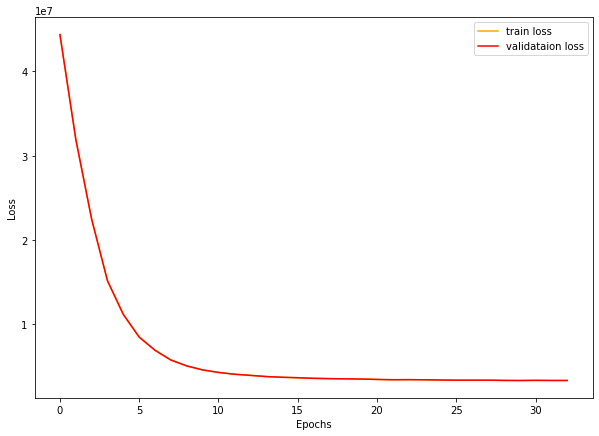

In [76]:
utils.save_loss_plot(train_loss, train_loss, sample_id)

In [77]:
np.zeros([trainset.genexp.shape[0],trainset.genexp.shape[1]+trainset.genexp_sig.shape[1]]).shape

(1162, 2491)

In [78]:
recon_exp_stack = np.zeros([trainset.genexp.shape[0],trainset.genexp.shape[1]+trainset.genexp_sig.shape[1]])
recon_img_stack = np.zeros([trainset.genexp.shape[0],patch_r*2,patch_r*2,1])
recon_poe_img_stack = np.zeros([trainset.genexp.shape[0],patch_r*2,patch_r*2,1])
recon_poe_rna_stack = np.zeros([trainset.genexp.shape[0],trainset.genexp.shape[1]+trainset.genexp_sig.shape[1]])

wholeimg_stitch = np.ones([2000,2000,1])*(-1)
recon_wholeimg_stitch = np.ones([2000,2000,1])*(-1)
recon_poe_wholeimg_stitch = np.ones([2000,2000,1])*(-1)

mu_exp_stack = np.zeros([trainset.genexp.shape[0],26])
mu_img_stack = np.zeros([trainset.genexp.shape[0],26])
mu_poe_stack = np.zeros([trainset.genexp.shape[0],26])

for i,(adata_variable, adata_sig, adata_img,data_loc) in enumerate(trainloader):

        mini_batch , num_varibale_gene  = adata_variable.shape
        _ , num_sig_gene = adata_sig.shape
        
        adata_img = adata_img.reshape(mini_batch,-1).float() # flatten the img
        

        # gene expression, 1D data
        adata_variable = adata_variable.to(device)  
        adata_sig = torch.Tensor(adata_sig).to(device)  
        recon_exp, recon_peri, mu_exp, logvar_exp, mu_peri, logvar_peri = model.predict_linVAE(adata_variable , adata_sig,  x_sample_variable.to(device),  x_sample_sig.to(device) )
        
        # image, 2D data
        adata_img = adata_img.to(device)  
        recon_img, mu_img, logvar_img = model.predict_imgVAE(adata_img)
        
        # POE
        recon_poe_rna, recon_poe_img, mu_poe,logvar_poe = model.predictor_POE(mu_exp, logvar_exp, mu_peri, logvar_peri, mu_img, logvar_img, adata_sig, x_sample_variable.to(device),  x_sample_sig.to(device) )
        
        for ii in range(mini_batch):
          loc = np.where(data_loc[ii]==map_info.index)
          recon_exp_stack[loc[0][0]] = recon_exp[ii].cpu().detach().numpy()
          recon_img_stack[loc[0][0]] = recon_img.reshape([recon_img.shape[0],patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy()
          recon_poe_img_stack[loc[0][0]] = recon_poe_img.reshape([recon_poe_img.shape[0],patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy()
          recon_poe_rna_stack[loc[0][0]] = recon_poe_rna[ii].cpu().detach().numpy()
          
          mu_exp_stack[loc[0][0]] = mu_exp[ii].cpu().detach().numpy()
          mu_img_stack[loc[0][0]] = mu_img[ii].cpu().detach().numpy()
          mu_poe_stack[loc[0][0]] = mu_poe[ii].cpu().detach().numpy()

          image_col = map_info.iloc[loc[0][0]]['imagecol']
          image_row = map_info.iloc[loc[0][0]]['imagerow']
        
          sample_id_ii = data_loc[ii].split('-')[-1]
          image_slide_z =np.where(np.array(sample_id)==sample_id_ii)[0][0]
        
          recon_wholeimg_stitch[int(image_row)-patch_r:int(image_row)+patch_r,int(image_col)-patch_r:int(image_col)+patch_r,image_slide_z] = recon_img.reshape([mini_batch,patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy().reshape([patch_r*2,patch_r*2])
          wholeimg_stitch[int(image_row)-patch_r:int(image_row)+patch_r,int(image_col)-patch_r:int(image_col)+patch_r,image_slide_z] = adata_img.reshape([mini_batch,patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy().reshape([patch_r*2,patch_r*2])
          recon_poe_wholeimg_stitch[int(image_row)-patch_r:int(image_row)+patch_r,int(image_col)-patch_r:int(image_col)+patch_r,image_slide_z] = recon_poe_img.reshape([mini_batch,patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy().reshape([patch_r*2,patch_r*2])

Text(0.5, 1.0, 'Inferred image from integration')

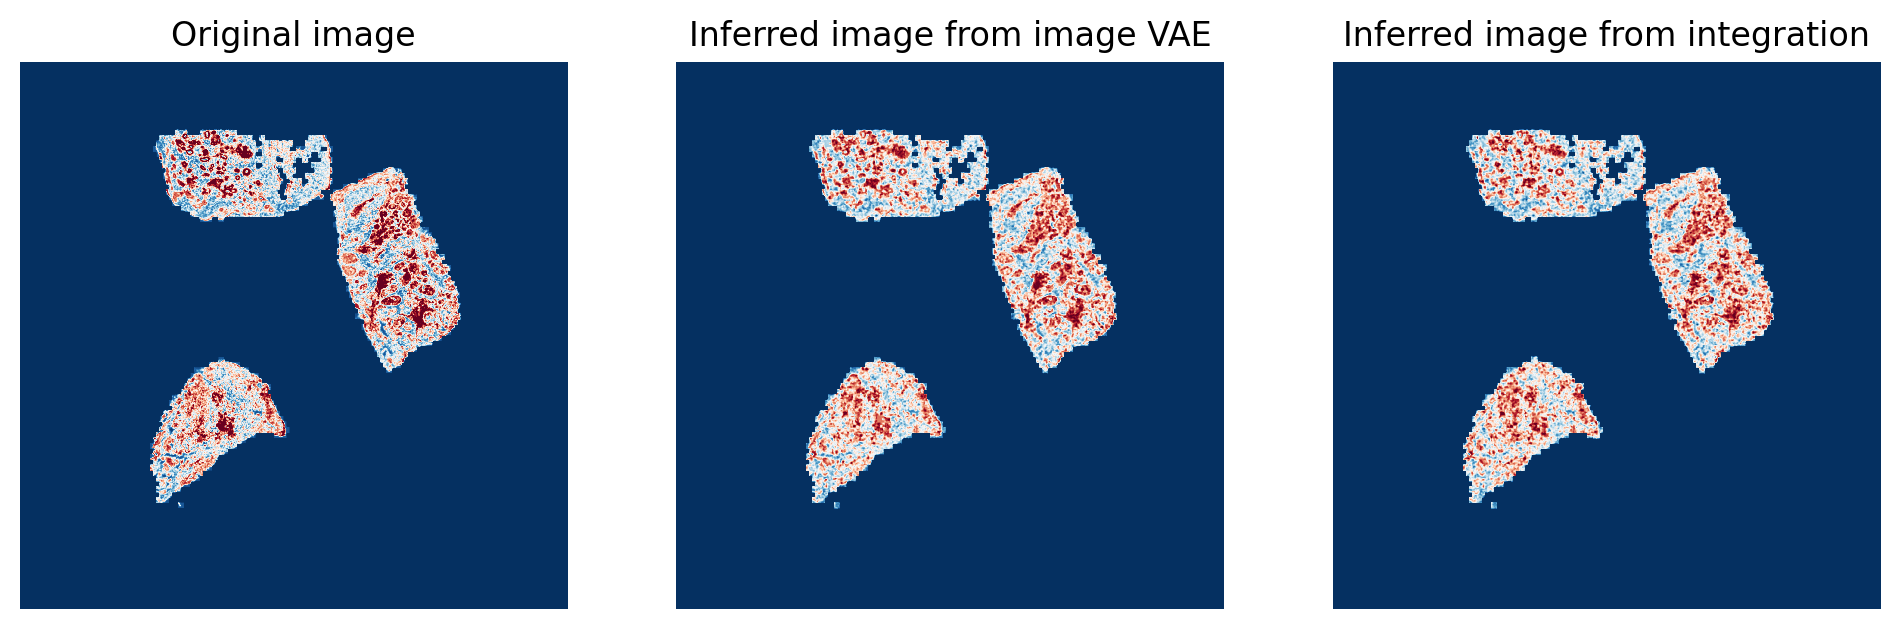

In [79]:
fig,axs=plt.subplots(1,3,figsize=(12,5),dpi=200)

image_slide_z = 0
vmax = 0.8
vmin = 0

ax=axs[0]
ax.imshow(wholeimg_stitch[:,:,image_slide_z],cmap='RdBu_r',vmax=vmax,vmin=vmin)
ax.axis('off')
ax.set_title('Original image')

ax=axs[1]
ax.imshow(recon_wholeimg_stitch[:,:,image_slide_z],cmap='RdBu_r',vmax=vmax,vmin=vmin)
ax.axis('off')
ax.set_title('Inferred image from image VAE')

ax=axs[2]
ax.imshow(recon_poe_wholeimg_stitch[:,:,image_slide_z],cmap='RdBu_r',vmax=vmax,vmin=vmin)
ax.axis('off')
ax.set_title('Inferred image from integration')

In [80]:
adata_df_concat = pd.concat([adata_df_variable,adata_df_signature], axis=1)

In [81]:
adata_df_concat.index

Index(['AACATTGGTCAGCCGT-1-CID444971', 'CATCGAATGGATCTCT-1-CID444971',
       'CGGGTTGTAGCTTTGG-1-CID444971', 'CCTAAGTGTCTAACCG-1-CID444971',
       'TCTGTGACTGACCGTT-1-CID444971', 'TTATCATACTCGCAAA-1-CID444971',
       'AGCGTAGCGCTAGACC-1-CID444971', 'AGGTCGCCACTTCGGT-1-CID444971',
       'TTGCTAGCTACCAATC-1-CID444971', 'GCCGGTTTGGGCGGAT-1-CID444971',
       ...
       'AGTGACTGTGACACAA-1-CID444971', 'GACCGATTAAATATGT-1-CID444971',
       'GTCGAATTTGGGCGCT-1-CID444971', 'TCACGGCCCAAGAGAG-1-CID444971',
       'CTACGATCCTATCCTA-1-CID444971', 'TGCAGTGGTAGGGAAC-1-CID444971',
       'AGCGAGACGTGAAGGC-1-CID444971', 'CAGTGTTAATCTCTCA-1-CID444971',
       'GATCGCTGTGGTGCGT-1-CID444971', 'CTCTGCAGGCATTCTT-1-CID444971'],
      dtype='object', length=1162)

Text(0.5, 1.0, 'Inferred exp (decoder3_POE) KRT15')

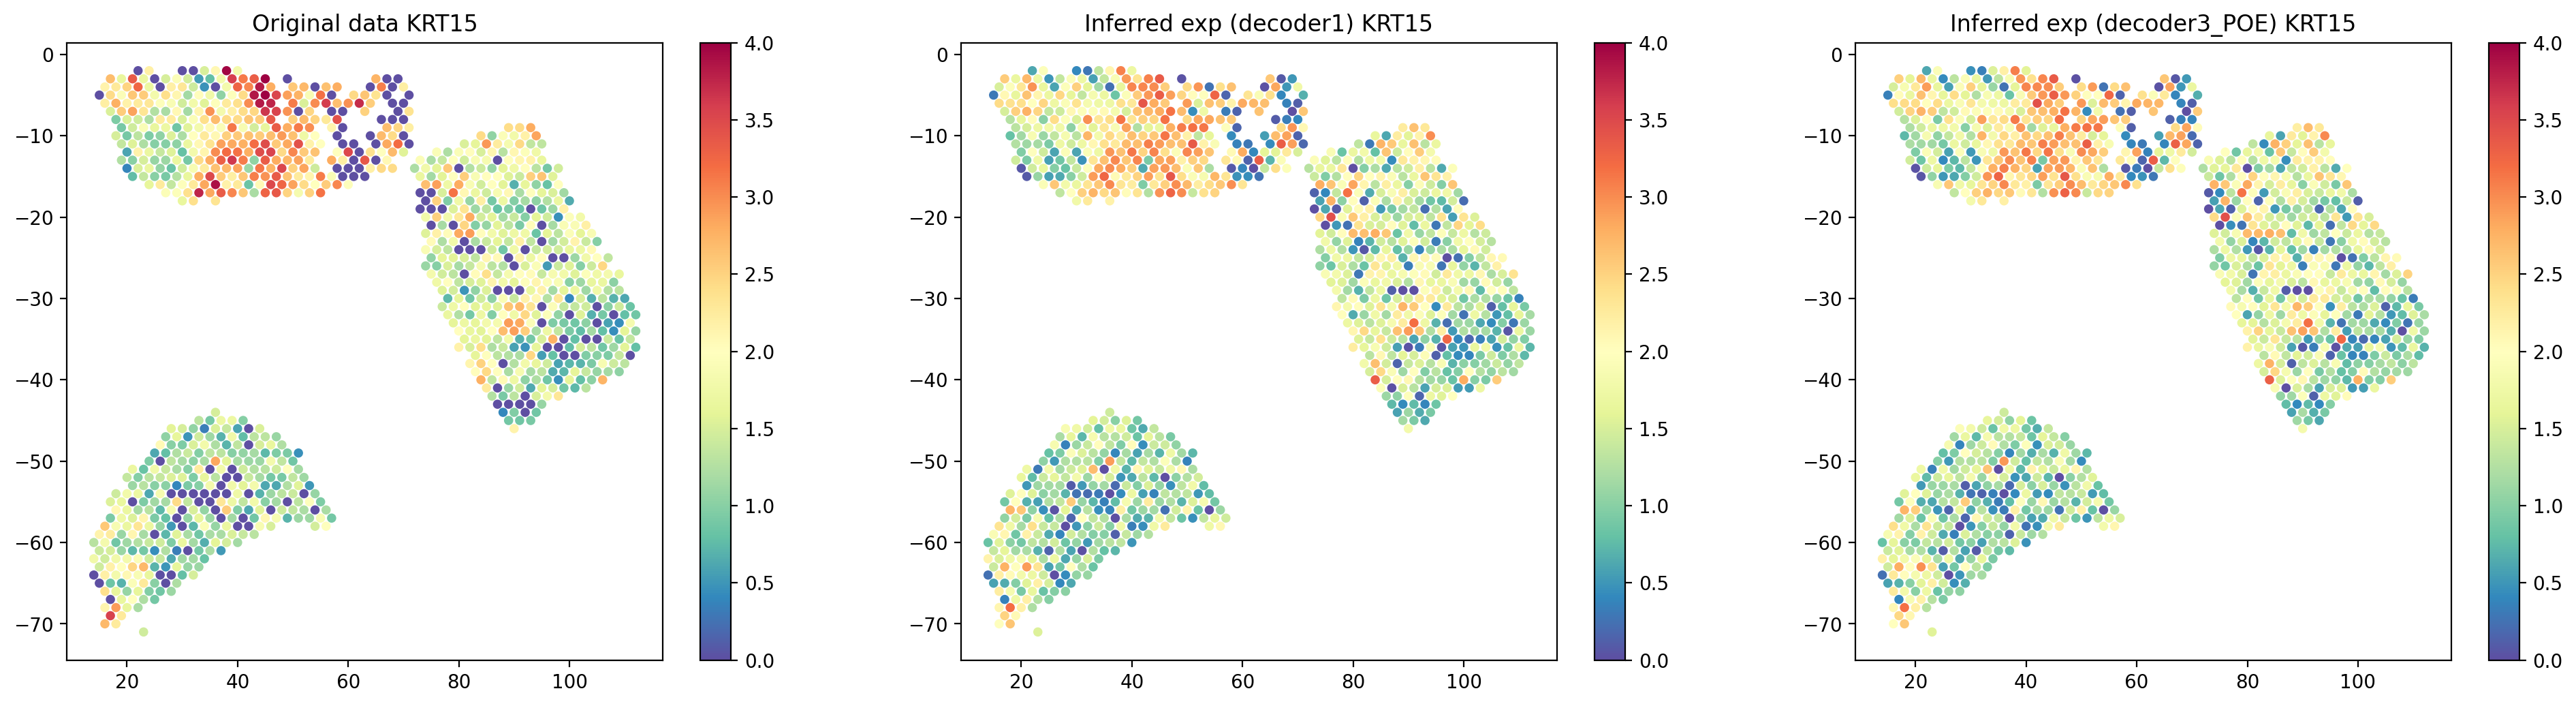

In [82]:
plotted_gene='KRT15'

c_max = 4
c_min = 0

image_slide_z =11

fig,axs=plt.subplots(1,3,figsize=(24,6),dpi=200)

ax=axs[0]

all_spot = np.array(adata_df_concat[ [spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in adata_df_concat.index ]])
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])

g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=15,c=all_spot[:,np.where(adata_df_concat.columns==plotted_gene)[0][0]],cmap='Spectral_r',vmax=c_max,vmin=c_min)
plt.colorbar(g, ax=ax)
ax.set_title('Original data '+plotted_gene)


ax=axs[1]
all_spot = recon_exp_stack[ [spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in adata_df_concat.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])
g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=15,c=all_spot[:,np.where(adata_df_concat.columns==plotted_gene)[0][0]],cmap='Spectral_r',vmax=c_max,vmin=c_min)
plt.colorbar(g, ax=ax)
ax.set_title('Inferred exp (decoder1) '+plotted_gene)

ax=axs[2]
all_spot = recon_poe_rna_stack[ [spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in adata_df_concat.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])
g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=15,c=all_spot[:,np.where(adata_df_concat.columns==plotted_gene)[0][0]],cmap='Spectral_r',vmax=c_max,vmin=c_min)
plt.colorbar(g, ax=ax)
ax.set_title('Inferred exp (decoder3_POE) '+plotted_gene)

In [189]:
0:'BC_lab_1A',
1:'BC_lab_1B',
2:'BC_lab_2A',
3:'BC_lab_2B',
4:'BC_lab_3A',
5:'BC_lab_3B',
6:'BC_lab_4A',
7:'BC_lab_4B',
8:'CID4290', (luminal A)
9:'CID4465', (TNBC)
10:'CID4535',(luminal B)
11:'CID444971', (TNBC)
12:'1142243F', (TNBC)
13:'1160920F' (TNBC)

SyntaxError: invalid syntax (<ipython-input-189-1871f1e68ef5>, line 1)

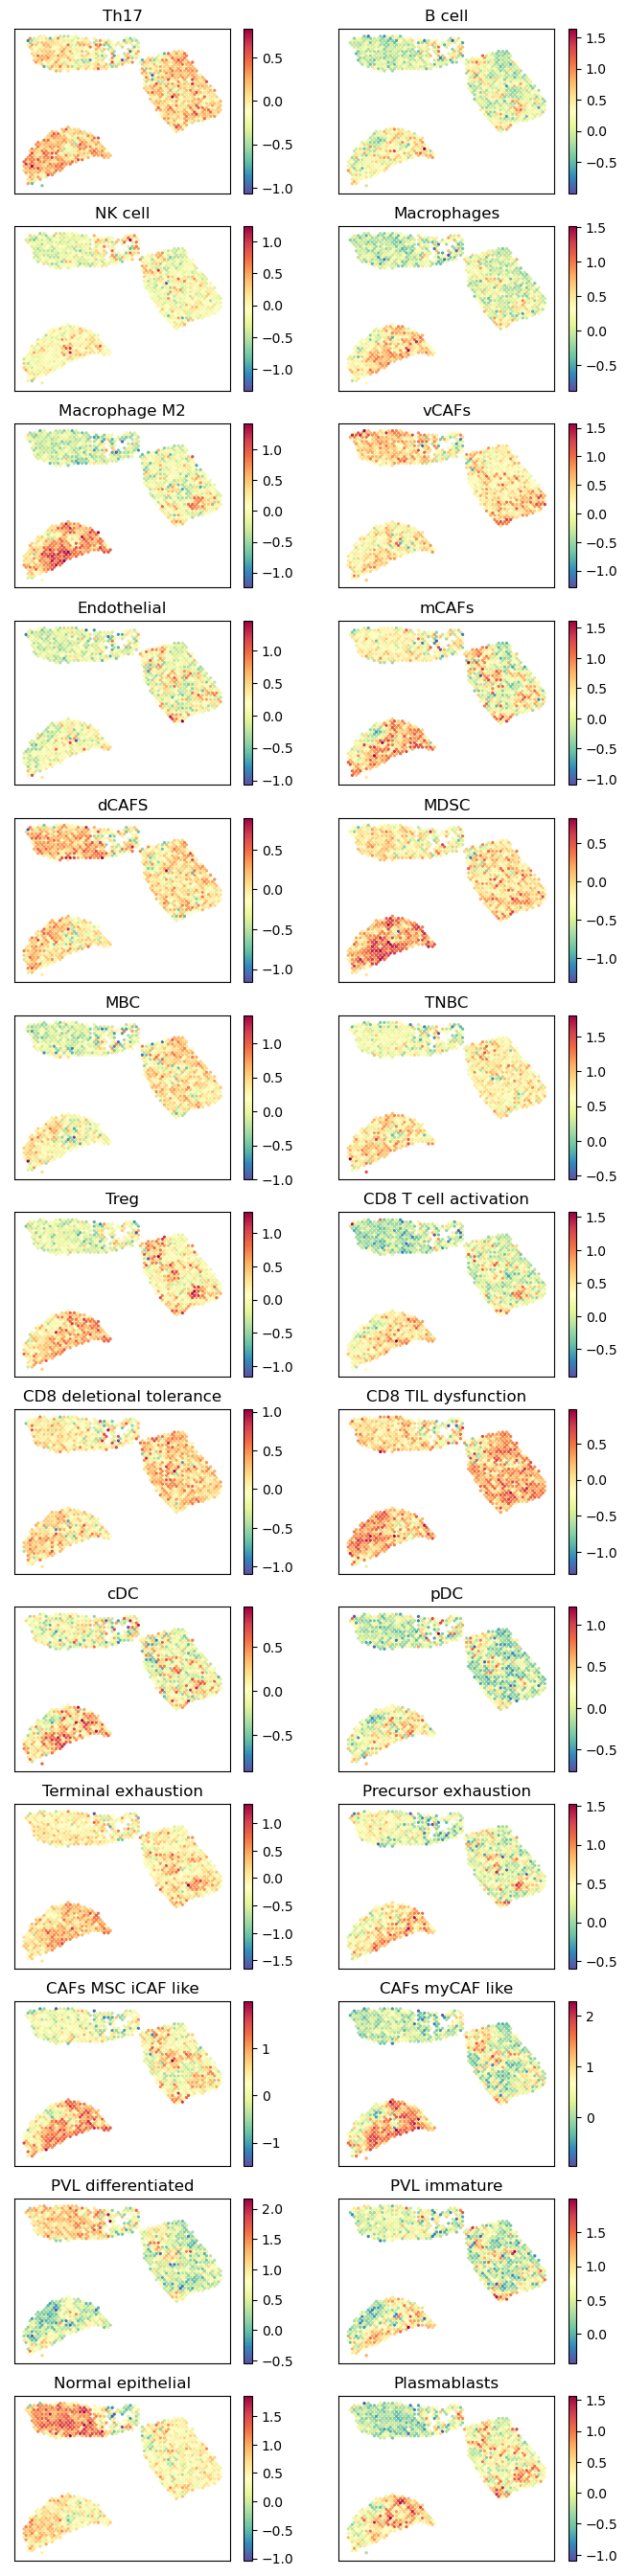

In [84]:
#'Inferred percent (decoder1)'
c_max = 3
c_min = -3

image_slide_z = 11


mu_exp_stack_df = pd.DataFrame(mu_exp_stack,columns=df_sig.columns,index = adata_df_concat.index)
all_spot = mu_exp_stack[[spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in mu_exp_stack_df.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])

fig,axs= plt.subplots(13,2,figsize=(8,35),dpi=100)
for i in range(13):
    for j in range(2):
        plotted_cell_idx = i*2+j
        if plotted_cell_idx<26:
            plotted_cell= df_sig.columns[plotted_cell_idx]
            ax=axs[i,j]
            g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=2,c=all_spot[:,plotted_cell_idx],cmap='Spectral_r',
                         #vmin=c_min, vmax=c_max
                        )
            plt.colorbar(g, ax=ax)
            ax.set_title(plotted_cell)
            ax.set_xticks([])
            ax.set_yticks([])

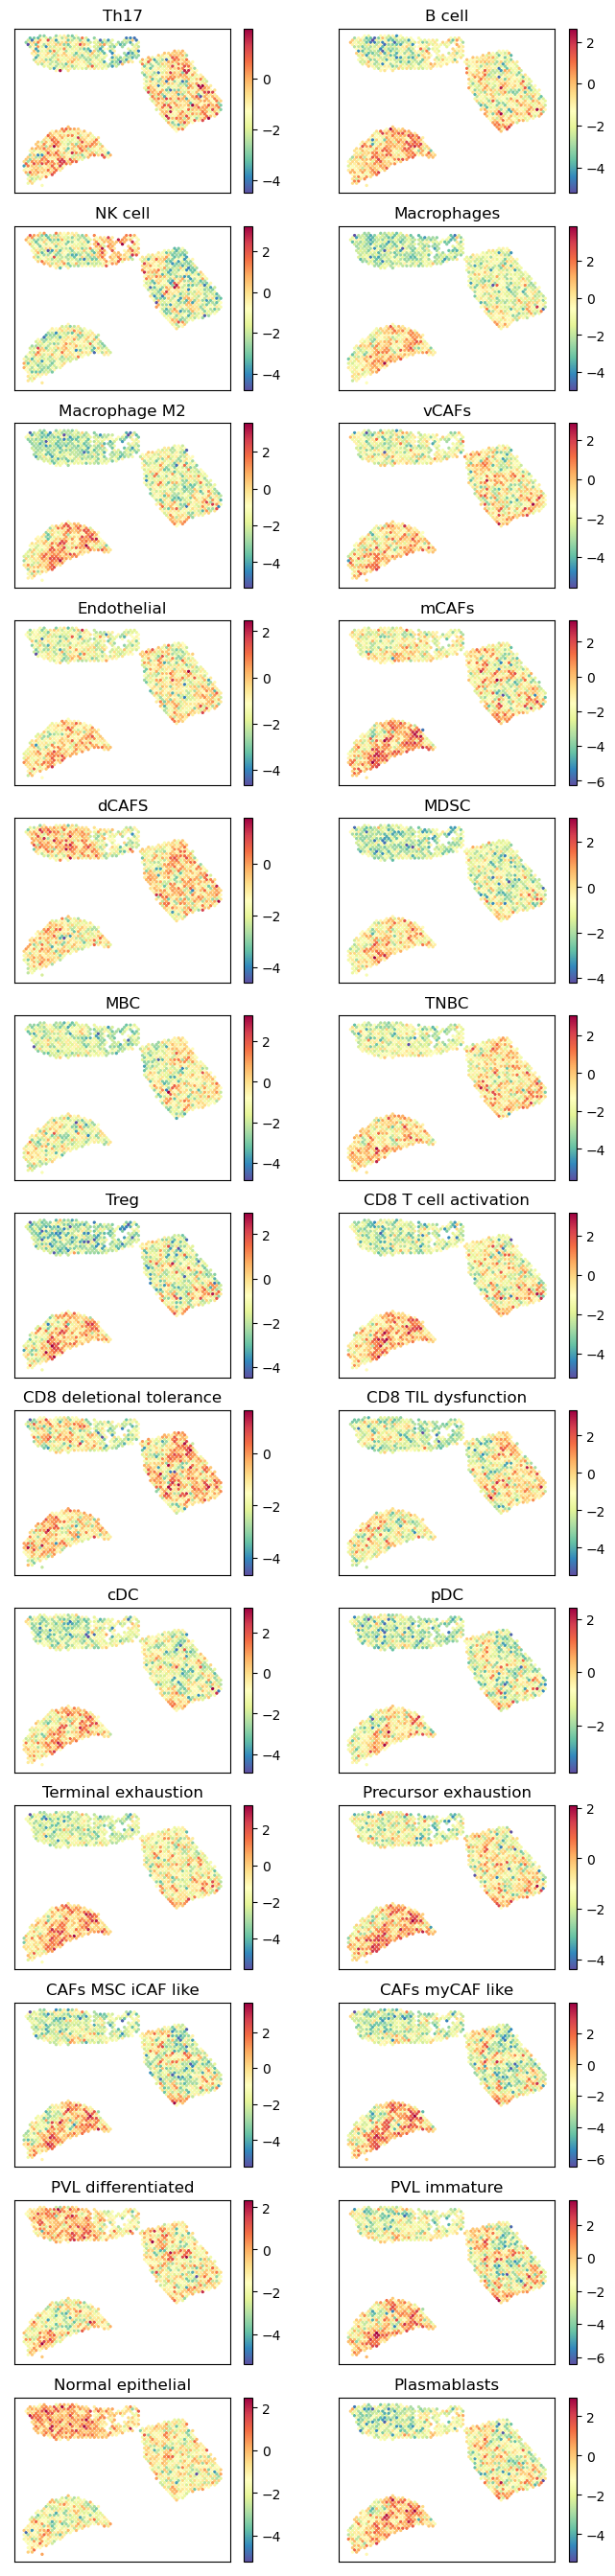

In [85]:
#'Inferred percent (decoder1)'
c_max = 1
c_min = -1

image_slide_z = 11


mu_poe_stack_df = pd.DataFrame(mu_poe_stack,columns=df_sig.columns,index = adata_df_concat.index)
all_spot = mu_poe_stack[[spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in mu_exp_stack_df.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])

fig,axs= plt.subplots(13,2,figsize=(8,35),dpi=100)
for i in range(13):
    for j in range(2):
        plotted_cell_idx = i*2+j
        if plotted_cell_idx<26:
            plotted_cell= df_sig.columns[plotted_cell_idx]
            ax=axs[i,j]
            g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=2,c=all_spot[:,plotted_cell_idx],cmap='Spectral_r',
                         #vmin=c_min, vmax=c_max
                        )
            plt.colorbar(g, ax=ax)
            ax.set_title(plotted_cell)
            ax.set_xticks([])
            ax.set_yticks([])

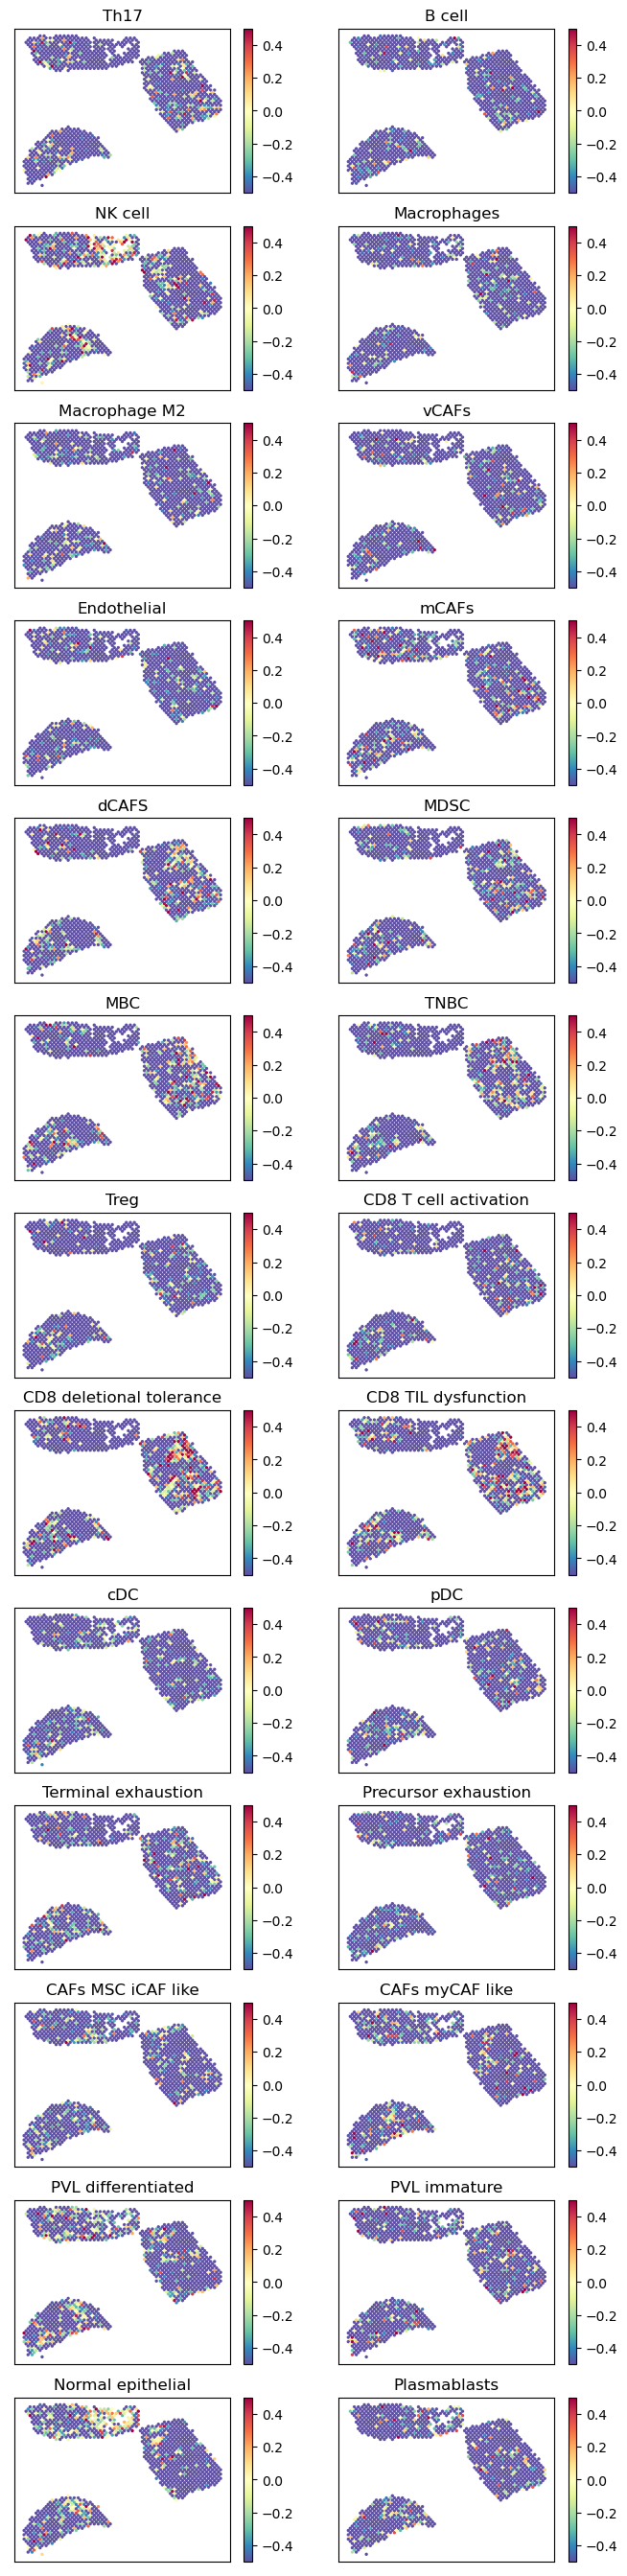

In [159]:
#'Inferred percent (decoder1)'
c_max = 0.5
c_min = -0.5

image_slide_z = 11


mu_img_stack_df = pd.DataFrame(mu_img_stack,columns=df_sig.columns,index = adata_df_concat.index)
all_spot = mu_img_stack[[spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in mu_img_stack_df.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])

fig,axs= plt.subplots(13,2,figsize=(8,35),dpi=100)
for i in range(13):
    for j in range(2):
        plotted_cell_idx = i*2+j
        if plotted_cell_idx<26:
            plotted_cell= df_sig.columns[plotted_cell_idx]
            ax=axs[i,j]
            g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=2,c=all_spot[:,plotted_cell_idx],cmap='Spectral_r',
                         vmin=c_min, vmax=c_max
                        )
            plt.colorbar(g, ax=ax)
            ax.set_title(plotted_cell)
            ax.set_xticks([])
            ax.set_yticks([])

TypeError: '(slice(None, None, None), 0)' is an invalid key

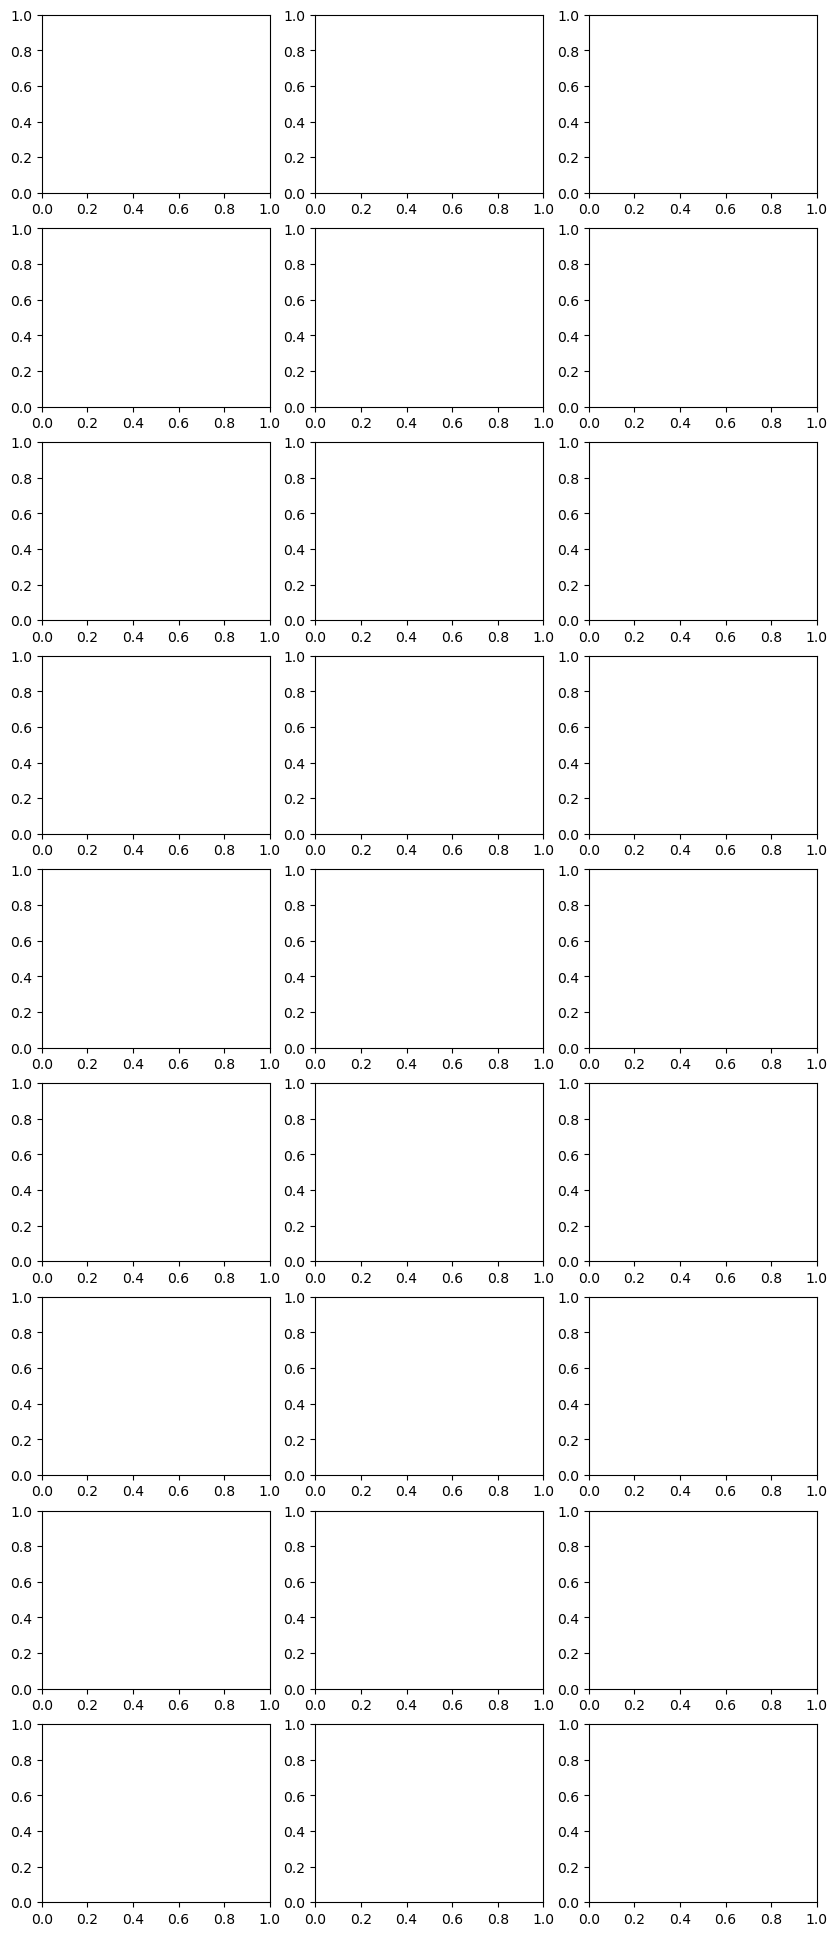

In [154]:
#'Inferred percent (decoder1)'
c_max = 1
c_min = -1

image_slide_z = 11


mu_exp_stack_df = pd.DataFrame(mu_poe_stack,columns=df_sig.columns,index = adata_df_concat.index)
all_spot = mu_exp_stack_df[[spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in mu_exp_stack_df.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])

fig,axs= plt.subplots(9,3,figsize=(10,25),dpi=100)
for i in range(9):
    for j in range(3):
        plotted_cell_idx = i*3+j
        if plotted_cell_idx<27:
            plotted_cell= df_sig.columns[plotted_cell_idx]
            ax=axs[i,j]
            g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=2,c=all_spot[:,plotted_cell_idx],cmap='Spectral_r',
                         vmin=c_min, vmax=c_max
                        )
            plt.colorbar(g, ax=ax)
            ax.set_title(plotted_cell)
            ax.set_xticks([])
            ax.set_yticks([])

Text(0.5, 1.0, 'TNBC')

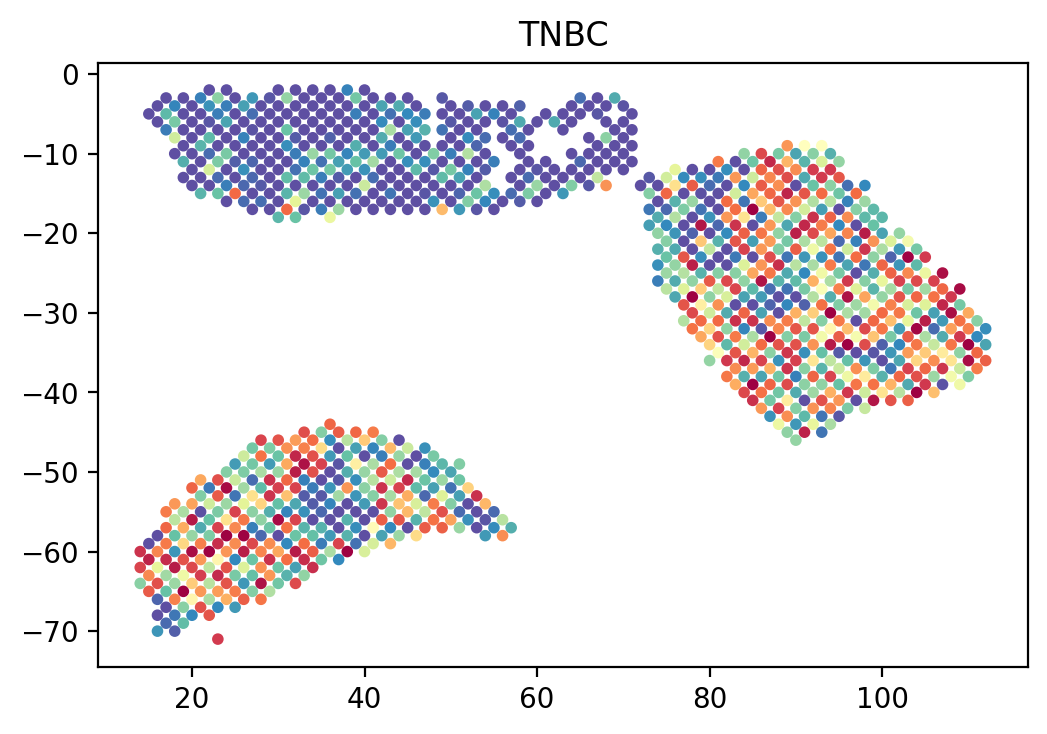

In [85]:
plotted_cell_idx = 11
plotted_cell= df_sig.columns[plotted_cell_idx]
plt.figure(dpi=200)
plt.scatter(all_loc[:,0],-all_loc[:,1],s=10,c=all_spot[:,plotted_cell_idx],cmap='Spectral_r',vmin=c_min, vmax=c_max)
plt.colorbar(g, ax=ax)
plt.title(plotted_cell)

IndexError: index 26 is out of bounds for axis 0 with size 26

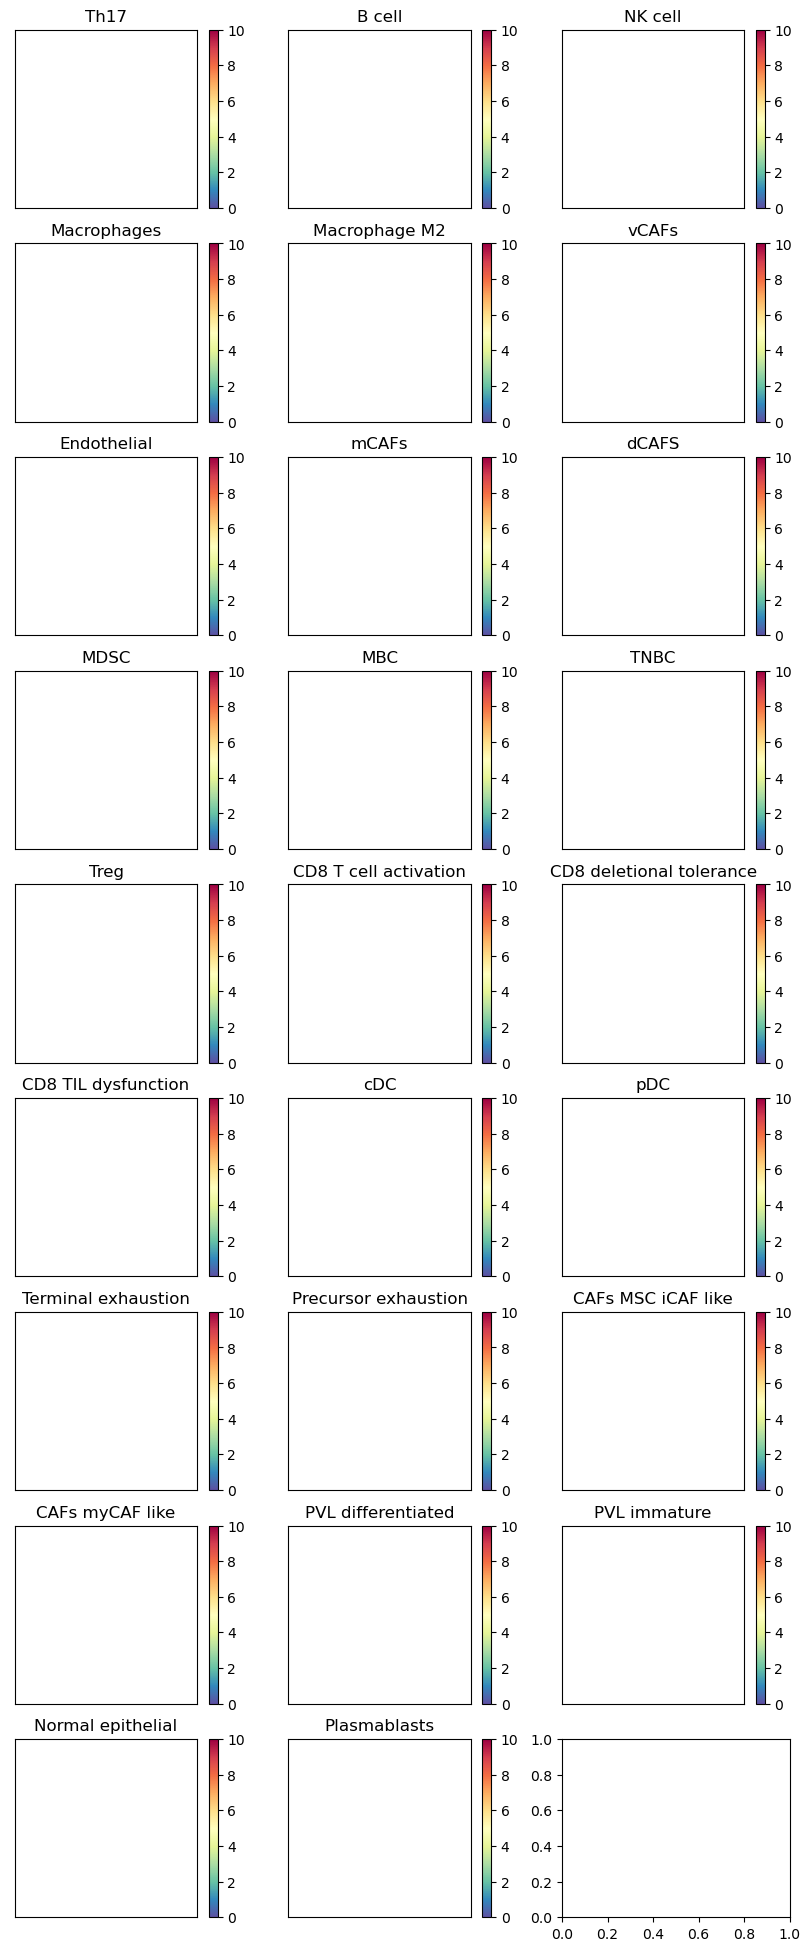

In [86]:
#'Inferred percent (decoder1)'
c_max = 10
c_min = 0

image_slide_z = 0


mu_exp_stack_df = pd.DataFrame(mu_exp_stack,columns=df_sig.columns,index = adata_df_concat.index)
all_spot = mu_exp_stack[[spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in mu_exp_stack_df.index ]]
all_loc = np.array(trainset.map_info.loc[trainset.map_info['sample']==sample_ids[image_slide_z],['array_col','array_row']])

fig,axs= plt.subplots(9,3,figsize=(10,25),dpi=100)
for i in range(9):
    for j in range(3):
        plotted_cell_idx = i*3+j
        if plotted_cell_idx<27:
            plotted_cell= df_sig.columns[plotted_cell_idx]
            ax=axs[i,j]
            g=ax.scatter(all_loc[:,0],-all_loc[:,1],s=2,c=all_spot[:,plotted_cell_idx],cmap='Spectral_r',vmin=c_min, vmax=c_max)
            plt.colorbar(g, ax=ax)
            ax.set_title(plotted_cell)
            ax.set_xticks([])
            ax.set_yticks([])

In [49]:
mu_poe_stack_df = pd.DataFrame(mu_poe_stack,columns=df_sig.columns,index = [i.replace("-"+sample_id, "") for i in adata_df_concat.index])
mu_poe_stack_df.to_csv(sample_id+'nb_file.csv')

In [50]:
mu_poe_stack_df

Th17    B cell   NK cell  Macrophages  Macrophage M2  \
AACATTGGTCAGCCGT-1 -0.562968 -0.588292 -1.395660    -1.413895      -1.028289   
CATCGAATGGATCTCT-1 -0.813382 -1.442365 -1.092090    -0.656862      -0.516277   
CGGGTTGTAGCTTTGG-1  0.166680 -0.617236 -1.424298    -1.871517      -0.515948   
CCTAAGTGTCTAACCG-1 -1.014789 -2.005059 -0.737344    -0.600111      -1.558702   
TCTGTGACTGACCGTT-1 -0.224051 -1.192631 -1.873493    -0.049512       0.165026   
...                      ...       ...       ...          ...            ...   
TGCAGTGGTAGGGAAC-1 -1.511050 -0.635448 -0.676849    -0.675775      -1.878869   
AGCGAGACGTGAAGGC-1 -1.651824 -1.524226 -0.215934    -1.107520      -0.880916   
CAGTGTTAATCTCTCA-1 -0.988742 -1.619724 -0.084949    -2.285669      -1.495519   
GATCGCTGTGGTGCGT-1 -1.403678 -1.621822 -0.372358    -0.845036      -0.793682   
CTCTGCAGGCATTCTT-1 -0.393546 -0.778896 -0.074505    -0.649825      -0.636665   

                       vCAFs  Endothelial     mCAFs     dCAFS      MDSC  ...  \
AACATTGGTCAGCCGT-1 -0.457360    -0.980774 -0.415547 -0.923428 -0.947398  ...   
CATCGAATGGATCTCT-1 -1.084505    -1.148042 -2.104367 -1.144064 -1.731741  ...   
CGGGTTGTAGCTTTGG-1 -0.908256    -1.519229 -1.228212 -0.392392 -1.685700  ...   
CCTAAGTGTCTAACCG-1 -1.008405    -0.199410  0.600952 -0.992872 -0.656418  ...   
TCTGTGACTGACCGTT-1 -0.463378    -0.653114 -1.641744 -0.000108 -1.160271  ...   
...                      ...          ...       ...       ...       ...  ...   
TGCAGTGGTAGGGAAC-1 -0.708623    -1.212401 -1.200081 -2.081255 -0.603268  ...   
AGCGAGACGTGAAGGC-1 -0.198959    -0.266219 -0.305904 -0.857683 -1.891163  ...   
CAGTGTTAATCTCTCA-1 -0.318050    -0.720695 -1.403200 -2.292927 -0.748861  ...   
GATCGCTGTGGTGCGT-1 -0.073557    -0.664415  0.089074 -1.396994 -1.611005  ...   
CTCTGCAGGCATTCTT-1 -0.276271    -0.340261 -0.171735 -0.473044 -0.113073  ...   

                    CD8 deletional tolerance  CD8 TIL dysfunction       cDC  \
AACATTGGTCAGCCGT-1                 -1.934427            -1.590659 -0.764337   
CATCGAATGGATCTCT-1                 -1.912202            -0.830648 -1.448550   
CGGGTTGTAGCTTTGG-1                 -1.210567            -0.902995 -1.292308   
CCTAAGTGTCTAACCG-1                 -1.671876            -1.346506 -2.509648   
TCTGTGACTGACCGTT-1                 -1.026926             0.155832 -1.331947   
...                                      ...                  ...       ...   
TGCAGTGGTAGGGAAC-1                 -1.616613            -1.860789 -1.039030   
AGCGAGACGTGAAGGC-1                 -1.270727            -0.856044 -0.646026   
CAGTGTTAATCTCTCA-1                 -1.349878            -0.798011 -0.748532   
GATCGCTGTGGTGCGT-1                 -0.515252            -1.874928 -0.693179   
CTCTGCAGGCATTCTT-1                 -1.382153            -0.674031 -0.636531   

                         pDC  Terminal exhaustion  Precursor exhaustion  \
AACATTGGTCAGCCGT-1 -1.158155            -1.098079             -1.248952   
CATCGAATGGATCTCT-1  0.285154            -2.534217             -0.782816   
CGGGTTGTAGCTTTGG-1 -3.017365            -0.973750             -0.396521   
CCTAAGTGTCTAACCG-1 -1.440689            -0.665570             -1.454316   
TCTGTGACTGACCGTT-1 -1.397954            -0.082178             -1.408032   
...                      ...                  ...                   ...   
TGCAGTGGTAGGGAAC-1 -0.835459            -0.438933             -0.566070   
AGCGAGACGTGAAGGC-1 -1.359972            -0.764119             -1.398703   
CAGTGTTAATCTCTCA-1 -0.229170            -1.314606             -0.744935   
GATCGCTGTGGTGCGT-1 -1.092739            -1.334385             -1.239040   
CTCTGCAGGCATTCTT-1 -0.564864            -0.390425             -0.208620   

                    CAFs MSC iCAF like  CAFs myCAF like  PVL Differentiated  \
AACATTGGTCAGCCGT-1           -0.211769        -0.293016           -0.063525   
CATCGAATGGATCTCT-1           -0.433875        -0.990855           -1.112692   
CGGGTTGTAGCTTTG